# EDA & Data-preprocessing

## 1. Setup and Environment
First, import the necessary libraries for our analysis. Using the pandas for data manipulation, numpy for numerical operations, matplotlib and seaborn for plotting, and nltk and spacy for natural language processing tasks.

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter

# NLP libraries
import spacy
from sklearn.model_selection import train_test_split

# Load spaCy model
try:
    nlp = spacy.load("en_core_web_sm")
except OSError:
    print("Downloading spaCy model 'en_core_web_sm'...")
    !python -m spacy download en_core_web_sm
    nlp = spacy.load("en_core_web_sm")

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("Libraries imported successfully.")

Libraries imported successfully.


## 2. Data Loading and Initial Inspection
Load the dataset from the provided Excel file and performing a preliminary check to understand its structure, data types, and look for any missing values.

In [5]:
# Load the dataset
# Make sure to update the path to where your file is located on Kaggle
file_path = 'E:/Btech_AI/Projects/Augnito/Spell-Correction-for-ASR-Noun-Enhancement/dataset/Spell_Correction_for_ASR_Noun_Enhancement_assignment_dataset.xlsx'
df = pd.read_excel(file_path)

# Display the first few rows of the dataframe
print("First 5 rows of the dataset:")
display(df.head())

# Get a concise summary of the dataframe
print("\nDataset Information:")
df.info()

# Check for any missing values
print("\nMissing Values Check:")
print(df.isnull().sum())

First 5 rows of the dataset:


,correct sentences,ASR-generated incorrect transcriptions
0,It is important to follow your doctor's instru...,It is important to follow your doctor's instru...
1,It's important to follow the prescribed dosage...,It's important to follow the prescribed dosage...
2,"""Improve your quality of life with CARTIGEN FO...",Improve your quality of life with Cartagan For...
3,Nadolol is a beta-blocker medicine commonly pr...,Natilol is a beta-blocker medicine commonly pr...
4,Remember to take EZOFIN PLUS regularly as pres...,Remember to take Ezefin Plus regularly as pres...



Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column                                  Non-Null Count  Dtype 
---  ------                                  --------------  ----- 
 0   correct sentences                       10000 non-null  object
 1   ASR-generated incorrect transcriptions  10000 non-null  object
dtypes: object(2)
memory usage: 156.4+ KB

Missing Values Check:
correct sentences                         0
ASR-generated incorrect transcriptions    0
dtype: int64


## 3. Dataset Structure Analysis
Here, lets analyze the core components of our dataset: the input features (ASR transcriptions) and target labels (ground truth sentences).  also analyzing sentence length and vocabulary size.

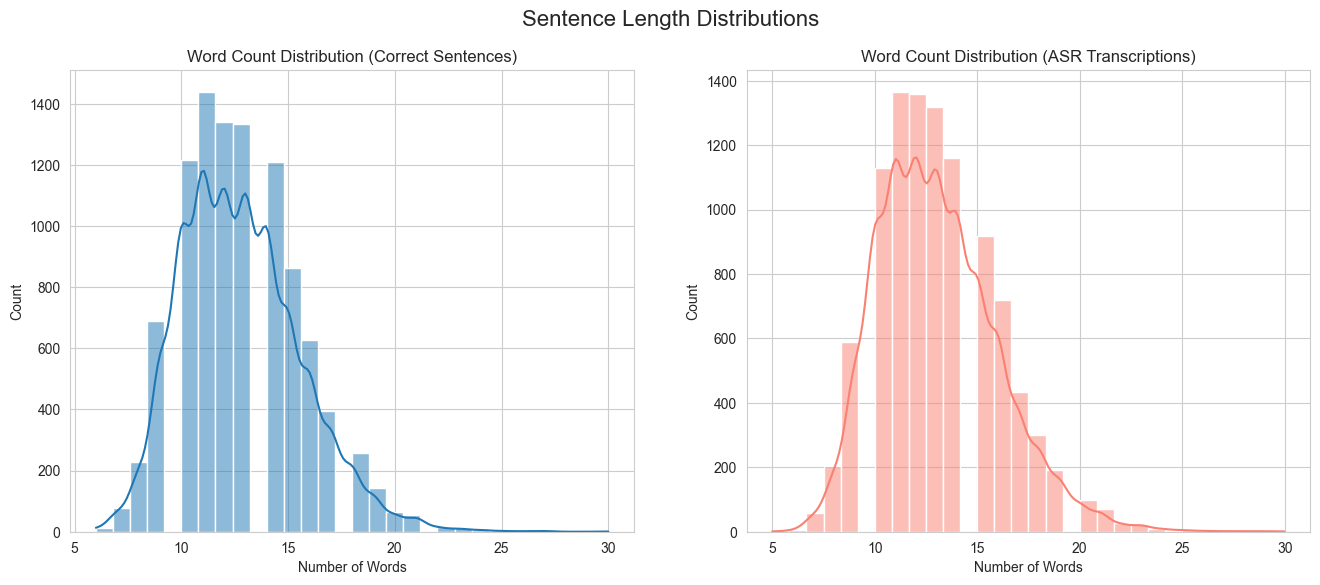


Sentence Length Statistics:


,correct_word_count,incorrect_word_count
count,10000.000000,10000.000000
mean,12.758400,13.036900
std,2.785463,2.910702
min,6.000000,5.000000
25%,11.000000,11.000000
50%,12.000000,13.000000
75%,14.000000,15.000000
max,30.000000,30.000000



Vocabulary Size (Correct Sentences): 13252
Vocabulary Size (ASR Transcriptions): 14575


In [7]:
# Identify input features and target labels
input_feature = "ASR-generated incorrect transcriptions"
target_label = "correct sentences"

# --- Analyze Sentence Length ---
# Calculate word count for each sentence
df['correct_word_count'] = df[target_label].str.split().str.len()
df['incorrect_word_count'] = df[input_feature].str.split().str.len()

# Plot the distributions
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
sns.histplot(df['correct_word_count'], ax=axes[0], kde=True, bins=30)
axes[0].set_title('Word Count Distribution (Correct Sentences)')
axes[0].set_xlabel('Number of Words')

sns.histplot(df['incorrect_word_count'], ax=axes[1], kde=True, bins=30, color='salmon')
axes[1].set_title('Word Count Distribution (ASR Transcriptions)')
axes[1].set_xlabel('Number of Words')

plt.suptitle('Sentence Length Distributions', fontsize=16)
plt.show()

print("\nSentence Length Statistics:")
display(df[['correct_word_count', 'incorrect_word_count']].describe())


# --- Analyze Vocabulary Size ---
def get_vocabulary(series):
    """Creates a vocabulary set from a pandas Series of sentences."""
    words = ' '.join(series.astype(str).tolist()).lower().split()
    return set(words)

correct_vocab = get_vocabulary(df[target_label])
incorrect_vocab = get_vocabulary(df[input_feature])

print(f"\nVocabulary Size (Correct Sentences): {len(correct_vocab)}")
print(f"Vocabulary Size (ASR Transcriptions): {len(incorrect_vocab)}")

## 4. Error Word Extraction and Analysis
This is a crucial step to understand the specific mistakes the ASR system makes. So need to compare sentence pairs to extract incorrectly transcribed words and analyze their frequency.

In [11]:
import difflib
import re

def clean_sentence_for_diff(text):
    """Cleans a sentence by lowercasing and removing punctuation."""
    text = str(text).lower()
    # Remove punctuation but keep hyphens in words like 'widely-used'
    text = re.sub(r'[^\w\s-]', '', text) 
    return text

def extract_error_words_diff_cleaned(row):
    """
    Compares pre-cleaned sentences using difflib to find true word errors.
    """
    # 1. Clean the entire sentences first
    correct_sent_clean = clean_sentence_for_diff(row[target_label])
    incorrect_sent_clean = clean_sentence_for_diff(row[input_feature])
    
    # 2. Split the now-clean sentences into words
    correct_words = correct_sent_clean.split()
    incorrect_words = incorrect_sent_clean.split()
    
    matcher = difflib.SequenceMatcher(None, correct_words, incorrect_words)
    
    error_list = []
    
    for tag, i1, i2, j1, j2 in matcher.get_opcodes():
        if tag == 'equal':
            continue
            
        # A 'replace' operation
        if tag == 'replace':
            for correct_word, incorrect_word in zip(correct_words[i1:i2], incorrect_words[j1:j2]):
                # 3. Only add pairs that are actually different
                if correct_word != incorrect_word:
                    error_list.append((correct_word, incorrect_word))

        # A 'delete' operation
        elif tag == 'delete':
            for word in correct_words[i1:i2]:
                error_list.append((word, '<DELETED>'))

        # An 'insert' operation
        elif tag == 'insert':
            for word in incorrect_words[j1:j2]:
                error_list.append(('<INSERTED>', word))
                
    return error_list

# Apply the new, more accurate function to the dataframe
df['error_pairs_diff'] = df.apply(extract_error_words_diff_cleaned, axis=1)

# Flatten the list of error pairs
all_error_pairs = [pair for sublist in df['error_pairs_diff'] for pair in sublist]

# Create a frequency count of the new error pairs
error_counts = Counter(all_error_pairs)

# Display the 50 most common error pairs
print("Top 50 Most Common Error Word Pairs (Correct -> ASR) using Pre-Cleaning:")
for (correct, incorrect), count in error_counts.most_common(50):
    print(f"'{correct}' -> '{incorrect}': {count} times")

Top 50 Most Common Error Word Pairs (Correct -> ASR) using Pre-Cleaning:
'healthcare' -> 'health': 712 times
'sulphate' -> 'sulfate': 44 times
'<INSERTED>' -> 'you': 44 times
'well-documented' -> 'well': 29 times
'maleate' -> 'malate': 28 times
'ofloxacin' -> 'ofluxacin': 27 times
'ofloxacin' -> 'afluxacin': 22 times
'widely-used' -> 'widely': 20 times
'amoxicillin' -> 'amexicillin': 19 times
'syr' -> 'sir': 19 times
'vitamin' -> 'vitam': 18 times
'aceclofenac' -> 'a': 18 times
'<INSERTED>' -> 'for': 14 times
'extended-release' -> 'extended': 13 times
'gel' -> 'gl': 13 times
'amoxycillin' -> 'amoxicillin': 13 times
'<INSERTED>' -> 'thank': 13 times
'chlorpheniramine' -> 'chlorophenyramine': 12 times
'<INSERTED>' -> 'watching': 12 times
'sulfate' -> 'sulphate': 12 times
'<INSERTED>' -> 'in': 12 times
'levocetirizine' -> 'levosterazine': 12 times
'ofloxacin' -> 'oflixacin': 11 times
'tamsulosin' -> 'tamsulos': 9 times
'rabeprazole' -> 'raprozole': 9 times
'glimepiride' -> 'glymperid': 9 



#### Error Type Classification

Our analysis of the extracted error pairs allows us to classify the ASR errors into several key types. A critical finding is that these error types are often intertwined, and the limitations of a non-contextual sequence-matching tool like `difflib` mean that one underlying ASR error can manifest as multiple distinct types in our analysis.

*   **1. Phonetic & Character-Level Substitutions:** These are direct, one-to-one word misspellings.
    *   *Example:* `'sulphate' -> 'sulfate'`
    *   *Example:* `'ofloxacin' -> 'ofluxacin'`

*   **2. Segmentation Errors (Word Boundary Issues):** This is a major category where the ASR system incorrectly splits or merges words. The key challenge is that this single error type creates a cascade effect in our analysis.
    *   **Example: Word Splitting:** The word `'healthcare'` is transcribed as `"health care"`. Our analysis tool, lacking context, logs this as two separate events:
        1.  A **replacement** (`'healthcare' -> 'health'`).
        2.  An **insertion** (`'<INSERTED>' -> 'care'`).

*   **3. Insertions and the Ambiguity Challenge:** This category consists of words added by the ASR system. Our analysis reveals a significant ambiguity in the source of these insertions:
    *   **Segmentation Artifacts:** As demonstrated above, many identified "insertions" are not genuine but are the second half of a word that the ASR system split.
    *   **Potentially Genuine Insertions:** We also observe the insertion of common conversational words (e.g., `'you'`, `'thank'`, `'watching'`). **However, we must be cautious.** Given how segmentation errors create artificial insertions, we cannot definitively conclude these are all genuine without a more sophisticated, context-aware model. They *appear* to be conversational filler, but this is a hypothesis that requires further validation during the modeling phase.

*   **4. Deletions:** The ASR system omits parts of words or entire words.
    *   *Example:* `'vitamin' -> 'vitam'` (Partial word deletion)

**Conclusion from EDA:** The interconnected nature of these errors, especially how segmentation creates phantom replacements and insertions, is the central challenge of this dataset. It proves that any effective correction system cannot treat words in isolation. It must analyze the entire sequence to understand the context and correctly identify whether to merge, split, substitute, or delete words. This provides an exceptionally strong justification for moving beyond simple baseline models to advanced sequence-to-sequence architectures like T5.

## 5. Data Preprocessing
Based on the analysis, lets define a two-part preprocessing strategy. The baseline model is simple and requires clean, standardized text, while advanced transformer models can handle more complex syntax. Therefore, lets create two distinct cleaning functions

#### 5.1 Verification of Bracketed Content
Brackets / Parentheses ([ ], ( )) -> This type of punctuation often encloses metadata or non-lexical sounds from the transcription process. It does not contribute to the medical context and should be removed.

Before deciding to remove all content in brackets and parentheses, verifying that it primarily contains non-lexical metadata is necessary

In [ ]:
import re
from collections import Counter

# Regex to find all content within square brackets or parentheses across the entire dataset
# We search in the raw ASR transcriptions as that's where this metadata is expected
all_text = ' '.join(df['ASR-generated incorrect transcriptions'].astype(str))
bracket_content = re.findall(r'\[(.*?)\]|\((.*?)\)', all_text)

# The regex returns tuples of ('content', '') or ('', 'content'), so we need to flatten and clean
all_content = [item[0] or item[1] for item in bracket_content if item[0] or item[1]]

# Count the frequency of each unique item
content_counts = Counter(all_content)

print("Top 10 Most Common Items Found in Brackets/Parentheses:")
if content_counts:
    for content, count in content_counts.most_common(10):
        print(f"'{content}': {count} times")
else:
    print("No bracketed or parenthetical content found.")




Top 10 Most Common Items Found in Brackets/Parentheses:
No bracketed or parenthetical content found.


#### 5.2 Defining Cleaning Functions

In [18]:
# --- 1. Text Cleaning ---
def clean_text_baseline(text):
    """
    An aggressive cleaning function for the baseline model.
    - Converts to lowercase.
    - Removes bracketed content.
    - Removes all punctuation, including apostrophes, keeping only alphanumeric, spaces, and hyphens.
    """
    text = str(text).lower()
    text = re.sub(r'\[.*?\]', '', text) # Remove content in brackets for future-proofing to help reduce noise
    text = re.sub(r'\(.*?\)', '', text) # Remove content in parentheses
    # This regex removes apostrophes and other punctuation
    text = re.sub(r'[^\w\s-]', '', text) 
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def clean_text_advanced(text):
    """
    A conservative cleaning function for advanced transformer models.
    - Converts to lowercase.
    - Removes bracketed content.
    - Preserves apostrophes and hyphens, removing other punctuation.
    """
    text = str(text).lower()
    text = re.sub(r'\[.*?\]', '', text) # Remove content in brackets for future-proofing to help reduce noise
    text = re.sub(r'\(.*?\)', '', text) # Remove content in parentheses
    # This regex keeps apostrophes (') and hyphens (-)
    text = re.sub(r"[^a-z0-9\s'-]", '', text) 
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Apply both cleaning functions to our dataframe for future use
df['correct_cleaned_baseline'] = df['correct sentences'].apply(clean_text_baseline)
df['incorrect_cleaned_baseline'] = df['ASR-generated incorrect transcriptions'].apply(clean_text_baseline)

df['correct_cleaned_advanced'] = df['correct sentences'].apply(clean_text_advanced)
df['incorrect_cleaned_advanced'] = df['ASR-generated incorrect transcriptions'].apply(clean_text_advanced)

print("Sample of the two different cleaning approaches:")
display(df[[
    'correct sentences', 
    'correct_cleaned_baseline', 
    'correct_cleaned_advanced'
]].head())

Sample of the two different cleaning approaches:


,correct sentences,correct_cleaned_baseline,correct_cleaned_advanced
0,It is important to follow your doctor's instru...,it is important to follow your doctors instruc...,it is important to follow your doctor's instru...
1,It's important to follow the prescribed dosage...,its important to follow the prescribed dosage ...,it's important to follow the prescribed dosage...
2,"""Improve your quality of life with CARTIGEN FO...",improve your quality of life with cartigen for...,improve your quality of life with cartigen for...
3,Nadolol is a beta-blocker medicine commonly pr...,nadolol is a beta-blocker medicine commonly pr...,nadolol is a beta-blocker medicine commonly pr...
4,Remember to take EZOFIN PLUS regularly as pres...,remember to take ezofin plus regularly as pres...,remember to take ezofin plus regularly as pres...


#### 5.3 POS Tagging and Data Splitting
 Performing POS tagging on the baseline-cleaned text to identify nouns for our baseline evaluation.Then split the entire dataframe, which now contains all the processed columns, into training, validation, and test sets.


In [19]:
import spacy
from sklearn.model_selection import train_test_split

# Load the spaCy model
nlp = spacy.load("en_core_web_sm")

def extract_nouns(text, spacy_model):
    """Extracts nouns from a sentence using spaCy."""
    doc = spacy_model(text)
    nouns = [token.text for token in doc if token.pos_ in ('NOUN', 'PROPN')]
    return nouns

# Apply noun extraction to the baseline-cleaned correct sentences
df['target_nouns'] = df['correct_cleaned_baseline'].apply(lambda x: extract_nouns(x, nlp))

print("\nSample of extracted nouns:")
display(df[['correct_cleaned_baseline', 'target_nouns']].head())

# --- Data Splitting (70-15-15) ---
# First, split into training (70%) and a temporary set (30%)
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42)

# Split the temporary set into validation (15%) and test (15%)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

print(f"\nDataset split sizes:")
print(f"Training set: {len(train_df)} rows ({len(train_df)/len(df):.0%})")
print(f"Validation set: {len(val_df)} rows ({len(val_df)/len(df):.0%})")
print(f"Test set: {len(test_df)} rows ({len(test_df)/len(df):.0%})")

# --- Save the processed data ---
# Saving the splits to CSV files for easy use in the next notebooks
train_df.to_csv('train.csv', index=False)
val_df.to_csv('validation.csv', index=False)
test_df.to_csv('test.csv', index=False)

print("\nProcessed and split datasets have been saved to train.csv, validation.csv, and test.csv")
print("This notebook is now complete.")


Sample of extracted nouns:


,correct_cleaned_baseline,target_nouns
0,it is important to follow your doctors instruc...,"[doctors, instructions, amlot, at]"
1,its important to follow the prescribed dosage ...,"[dosage, nusaid, sp, results]"
2,improve your quality of life with cartigen for...,"[quality, life, cartigen, forte, solution, pain]"
3,nadolol is a beta-blocker medicine commonly pr...,"[nadolol, beta, blocker, medicine, heart, cond..."
4,remember to take ezofin plus regularly as pres...,"[ezofin, healthcare, provider, condition]"



Dataset split sizes:
Training set: 7000 rows (70%)
Validation set: 1500 rows (15%)
Test set: 1500 rows (15%)

Processed and split datasets have been saved to train.csv, validation.csv, and test.csv
This notebook is now complete.
